The artificial NN model works great for predicting bad cycle which we have a record for - it can capture criminals who have records, but not good at identifying new criminals because we are lacking alarm data. So, we can further filter the cycles that are marked as "healthy" with an Autoencoder reconstruction loss, which recognizes healthy cycle patterns and would have a higher loss for ones whose feature deviate from the normal ones.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from tensorflow import keras
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline 
import os 
import shap
import random
import dill


In [ ]:
# drop bad cycles, non PREVAC cycles, and [cycle_type] columns for autoencoder
# want to just focus on PREVAC for now
dataframe = pd.read_csv("dataset2.csv")
dataframe = dataframe[dataframe['cycle_type'] == 'PREVAC']
bad_cycles = dataframe[dataframe['FSR_Required'] != 0]
dataframe = dataframe[dataframe['FSR_Required'] == 0]

bad_cycles.drop("cycle_type", axis=1, inplace=True)
bad_cycles.drop("FSR_Required", axis=1, inplace=True)

dataframe.drop("cycle_type", axis=1, inplace=True)
dataframe.drop("FSR_Required", axis=1, inplace=True)

# split the data into training and validation set
val_dataframe = dataframe.sample(frac=0.2, random_state=7491)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation for Autoencoder"
    % (len(train_dataframe), len(val_dataframe))
)

# use MaxAbsScaler to normalize because our data is all non-negative and it does not impact categorical data
# normalize training, validation and bad_cycles
abs_scaler = MaxAbsScaler()
abs_scaler.fit(train_dataframe)
train_scaled = abs_scaler.transform(train_dataframe)
train_scaled = pd.DataFrame(train_scaled, columns=train_dataframe.columns)

MAX_ABS_ = abs_scaler.max_abs_
print(f"The max absolute normalization factor for this dataset is {MAX_ABS_}")

val_scaled = abs_scaler.transform(val_dataframe)
val_scaled = pd.DataFrame(val_scaled, columns=val_dataframe.columns)

bc_scaled = abs_scaler.transform(bad_cycles)
bc_scaled = pd.DataFrame(bc_scaled, columns=bad_cycles.columns)

Construct the Autoencoder

In [ ]:
# still use the encoded features as input for an extra layer of encoding
# input = feature_space_autoencoder.get_encoded_features()
# 
# Could use "leaky_relu" instead of "relu" to avoid Dying ReLu problem but SHAP 0.42.1
# doesn't seem to be compatible with 'leaky_relu'
input = keras.Input(shape=train_scaled.shape[1])
encoded = keras.layers.Dense(64, activation='relu', bias_initializer=tf.keras.initializers.Constant(0.1))(input)
encoded = keras.layers.Dense(32, activation='relu', bias_initializer=tf.keras.initializers.Constant(0.1))(encoded)
encoded = keras.layers.Dense(16, activation='relu', bias_initializer=tf.keras.initializers.Constant(0.1))(encoded)

decoded = keras.layers.Dense(32, activation='relu', bias_initializer=tf.keras.initializers.Constant(0.1))(encoded)
decoded = keras.layers.Dense(64, activation='relu', bias_initializer=tf.keras.initializers.Constant(0.1))(decoded)
decoded = keras.layers.Dense(train_dataframe.shape[1], activation='sigmoid')(decoded)

autoencoder_model = keras.Model(inputs=input, outputs=decoded)
autoencoder_model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
autoencoder_model.summary()

Train the model

In [ ]:
autoencoder_model.fit(
    train_scaled,
    train_scaled,
    epochs=10,
    validation_data=(val_scaled, val_scaled),
    verbose=2,
)

Naive approach to get and interpret the loss

In [ ]:
# Takes a DataFrame sample and a trained model
# Returns the mean-sqaured error between the sample and the sample reconstructed by the model
def predict_loss(sample, autoencoder):
    prediction = autoencoder.predict(sample)
    loss = tf.keras.losses.mean_squared_error(sample, prediction)
    return loss.numpy()[0]

In [27]:
# use a random healthy cycle
sample = val_scaled.sample()
loss = predict_loss(sample, autoencoder_model)
print(f"This particular cycle had a variation (difference) of {loss * 100}% comparing to a normal cycle")

# use a random unhealthy cycle
sample = bc_scaled.sample()
# setting a column to a peak value guarantees the loss to be significantly higher
sample['CPRES_peak'] = 2
loss = predict_loss(sample, autoencoder_model)
print(f"This particular cycle had a variation (difference) of {loss * 100}% comparing to a normal cycle")


1/1 [==============================] - 0s 74ms/step
This particular cycle had a variation (difference) of 0.19896309822797775% comparing to a normal cycle
1/1 [==============================] - 0s 44ms/step
This particular cycle had a variation (difference) of 3.5713300108909607% comparing to a normal cycle


SHAP approach to visualize and interpret the lose

In [ ]:
explainer = shap.DeepExplainer(autoencoder_model, train_scaled.values)
# shap_values = explainer.shap_values(val_scaled.values)

Ideally, the explainer should be saved instead of being generated everytime. However, it seems like there has not been much success worldwide in saving a SHAP DeepExplainer object using pickle/cloudpickle/or Dill so a solution would be to simplify the model..

In [ ]:
# Gives an error
# with open('Autoencoder_SHAP_exp.pkl', 'wb') as f:
#     dill.dump(explainer, f)

In [57]:
sample = val_scaled.sample().values
bad_sample = bc_scaled.sample().values
shap_values = explainer.shap_values(sample)
shap.initjs()
shap.summary_plot(shap_values[0], plot_type='bar', feature_names=train_dataframe.iloc[:, :-1].columns, max_display=7)

KeyboardInterrupt: 

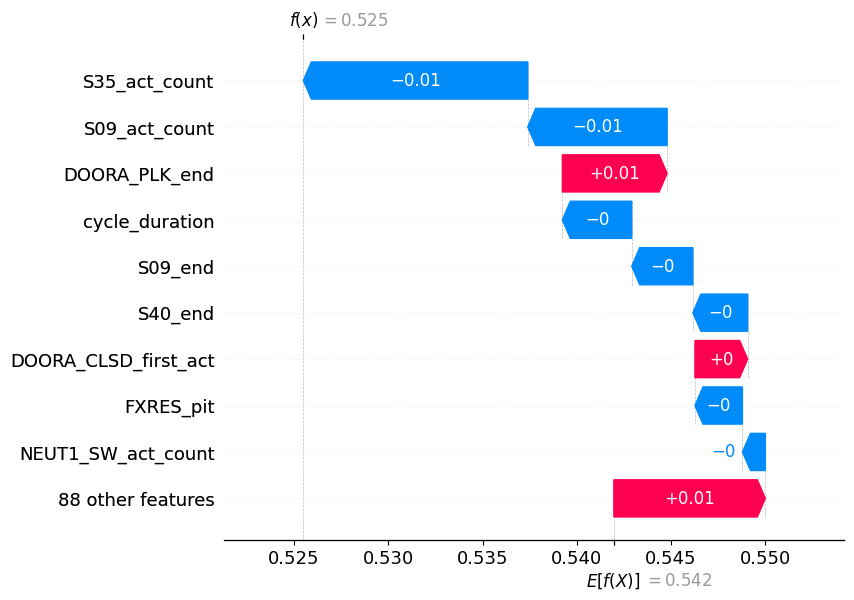

In [39]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], feature_names=train_dataframe.iloc[:, :-1].columns)

In [62]:
# The threshold of the model represents the "baseline" of a good cycle learned by training.
# Output represents how similar/different a particular cycle is from the good, baseline pattern.
baseline = explainer.expected_value[0]
prediction = autoencoder_model.predict(sample)
diff = np.sum(((baseline - prediction)/baseline))

print(f"This particular cycle has a mutant (abnormal) score of {diff}%")


bad_prediction = autoencoder_model.predict(bad_sample)
bad_diff = np.sum(((baseline - bad_prediction)/baseline))

print(f"This particular cycle has a mutant (abnormal) score of {bad_diff}%")

1/1 [==============================] - 0s 30ms/step
This particular cycle has a mutant (abnormal) score of 71.52227783203125%
1/1 [==============================] - 0s 42ms/step
This particular cycle has a mutant (abnormal) score of 69.8951416015625%
